In [27]:
import sqlite3

conn = sqlite3.connect('arenda.sqlite3')
conn.close()

conn = sqlite3.connect('arenda.sqlite3')
curs = conn.cursor()

script = """CREATE TABLE object ( 
                id_object TEXT NOT NULL PRIMARY KEY,
                object_region TEXT,
                object_square REAL NOT NULL,
                rooms_number REAL NOT NULL,
                floor REAL,
                subway TEXT,
                living_complex TEXT,
                price REAL
                ) 
                """

curs.executescript(script)
conn.close()

In [30]:
HEADERS = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:49.0) Gecko/20100101 Firefox/49.0',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'DNT': '1',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1'
        }

import requests
from bs4 import BeautifulSoup

BASE = []
for page in range (1,430):
    SITE = f'https://100realty.ua/realty_search/apartment/rent/nr_1%2C2%2C3%2C4%2C5_/p_5000_/cur_3/kch_2?page={page}'

    r = requests.get(SITE, headers = HEADERS)

    if r.status_code == 200:
        soup = BeautifulSoup(r.text, 'lxml')
        
        for el in soup.find_all('div', class_ = "object-common-wrapper"): 
            id_ = el.find('div', class_ = "object-address")
            id_object = id_.find('a').get('href').replace('/object/','')
            link = 'https://100realty.ua/' + id_.find('a').get('href')
            
            try:
                object_region = el.find('div', class_ = "object-region").text.split(', ')[1].replace('\n','')
            except IndexError as e:
                object_region = None
                
            object_square = el.find('div', class_ = "object-square object-info-item").text.replace('Площадь (общая):','').replace(' м²','').replace('\n','')
            
            rooms_number = el.find('div', class_ = "object-rooms object-info-item").text.replace('Кол-во комнат:','').replace('\n','')
            
            fl = el.find('div', class_ = "object-floors object-info-item")
            if fl is not None:
                floor = fl.find('div', class_ = "value").text.split('/')[0]
            else:
                floor = None
                
            s = el.find('div', class_ = "area")
            if s is not None:
                subway = s.find('span').text.replace('\n','')
            else:
                subway = None
            
            v = el.find('div', class_ = "object-resident object-info-item") 
            if v is not None:
                living_complex = v.find('div', class_ = "value").text
            else:
                living_complex = None
                
            pr = el.find('div', class_ = "cost-field") 
            unformatted_price = pr.find('span').text.replace(' грн./месяц','').replace('*','')
            price = int(unformatted_price.replace(' ',''))
    
            BASE = [ (id_object, object_region, object_square, rooms_number, floor, subway, living_complex, price) ]
        
            for object_info in BASE:
                conn = sqlite3.connect('arenda.sqlite3')
                curs = conn.cursor()

                p = "INSERT INTO object VALUES (?, ?, ?, ?, ?, ?, ?, ?)"
                try:
                    curs.execute(p, object_info)
                    conn.commit()
                except Exception as e:
                    print(e)

                conn.close()

In [323]:
import pandas as pd
import sqlite3

con = sqlite3.connect("arenda.sqlite3")
df = pd.read_sql_query("SELECT * from object", con)

print(df.head())

con.close()

   id_object       object_region  object_square  rooms_number floor  \
0  375726424                None          228.0           7.0  None   
1  375708417   Соломенский район          160.0           3.0  None   
2  375687794  Голосеевский район          125.0           3.0  None   
3  375594849     Печерский район          118.0           3.0  None   
4  375335493     Печерский район          150.0           3.0  None   

                                              subway     living_complex  \
0  метро Площадь Льва Толстого, метро Олимпийская...               None   
1                                               None               None   
2  метро Олимпийская (Республиканский стадион), м...  Парк-холл Горький   
3                                    метро Печерская               None   
4  метро Майдан Незалежности, метро Арсенальная, ...      Липская Башня   

      price  
0  166000.0  
1   44200.0  
2   49800.0  
3   71900.0  
4  138000.0  


In [324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8580 entries, 0 to 8579
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_object       8580 non-null   object 
 1   object_region   8077 non-null   object 
 2   object_square   8580 non-null   float64
 3   rooms_number    8580 non-null   float64
 4   floor           4502 non-null   object 
 5   subway          5370 non-null   object 
 6   living_complex  2966 non-null   object 
 7   price           8580 non-null   float64
dtypes: float64(3), object(5)
memory usage: 536.4+ KB


In [325]:
df.head()

,id_object,object_region,object_square,rooms_number,floor,subway,living_complex,price
0,375726424,None,228.0,7.0,None,"метро Площадь Льва Толстого, метро Олимпийская...",None,166000.0
1,375708417,Соломенский район,160.0,3.0,None,None,None,44200.0
2,375687794,Голосеевский район,125.0,3.0,None,"метро Олимпийская (Республиканский стадион), м...",Парк-холл Горький,49800.0
3,375594849,Печерский район,118.0,3.0,None,метро Печерская,None,71900.0
4,375335493,Печерский район,150.0,3.0,None,"метро Майдан Незалежности, метро Арсенальная, ...",Липская Башня,138000.0


In [327]:
df = df[df.notnull()['floor']]

In [328]:
df.isnull().sum()

id_object            0
object_region      166
object_square        0
rooms_number         0
floor                0
subway            1930
living_complex    3022
price                0
dtype: int64

In [329]:
df = df[df.notnull()['object_region']]

In [330]:
df['object_region'].value_counts()

Печерский район         1193
Шевченковский район      766
Голосеевский район       435
Дарницкий район          421
Соломенский район        370
Днепровский район        306
Оболонский район         250
Подольский район         227
Святошинский район       178
Деснянский район          95
Голосеевский (центр)      95
Name: object_region, dtype: int64

In [25]:
import pickle

pickle_off = open("districts.pickle","rb")
districts = pickle.load(pickle_off)
pickle_off.close()
print(districts)

          total transport infrastructure  rest security   eko
Голосіїв   10.0      10.0           10.0  10.0     10.0  10.0
Оболонь     9.7       9.7            9.9   9.8      9.7   9.6
Мишоловка   9.6       8.0           10.0  10.0     10.0  10.0
Теремки-2   9.0       9.0            9.0   9.0      9.0   9.0
Китаїв      8.7       8.8            6.0   9.3      9.5  10.0
...         ...       ...            ...   ...      ...   ...
Монтажник   1.0       1.0            1.0   1.0      1.0   1.0
Жовтневе    1.0       1.0            1.0   1.0      1.0   1.0
Петрівка    1.0       1.0            1.0   1.0      1.0   1.0
Перемога    1.0       1.0            1.0   1.0      1.0   1.0
Кудрявець   1.0       1.0            1.0   1.0      1.0   1.0

[99 rows x 6 columns]


In [331]:
df['object_region'] = df['object_region'].replace(['Печерский район'],'8.4')
df['object_region'] = df['object_region'].replace(['Шевченковский район'],'7.6')
df['object_region'] = df['object_region'].replace(['Голосеевский район', 'Голосеевский (центр)'],'10')
df['object_region'] = df['object_region'].replace(['Дарницкий район'],'7.2')
df['object_region'] = df['object_region'].replace(['Соломенский район'],'7.5')
df['object_region'] = df['object_region'].replace(['Днепровский район'],'7.0')
df['object_region'] = df['object_region'].replace(['Оболонский район'],'9.7')
df['object_region'] = df['object_region'].replace(['Подольский район'],'7.9')
df['object_region'] = df['object_region'].replace(['Святошинский район'],'6.8')
df['object_region'] = df['object_region'].replace(['Деснянский район'],'5.8')
df['object_region'].value_counts()

8.4    1193
7.6     766
10      530
7.2     421
7.5     370
7.0     306
9.7     250
7.9     227
6.8     178
5.8      95
Name: object_region, dtype: int64

In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336 entries, 7 to 8578
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_object       4336 non-null   object 
 1   object_region   4336 non-null   object 
 2   object_square   4336 non-null   float64
 3   rooms_number    4336 non-null   float64
 4   floor           4336 non-null   object 
 5   subway          2489 non-null   object 
 6   living_complex  1426 non-null   object 
 7   price           4336 non-null   float64
dtypes: float64(3), object(5)
memory usage: 304.9+ KB


In [333]:
f = lambda x: 0.0 if x==None else 1.0
df['living_complex'] = df['living_complex'].map(f)

df['living_complex'].value_counts()

0.0    2910
1.0    1426
Name: living_complex, dtype: int64

In [334]:
d = lambda x: 2.0 if x==None else 3.0
df['subway'] = df['subway'].map(d)


df['subway'].value_counts()

3.0    2489
2.0    1847
Name: subway, dtype: int64

In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336 entries, 7 to 8578
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_object       4336 non-null   object 
 1   object_region   4336 non-null   object 
 2   object_square   4336 non-null   float64
 3   rooms_number    4336 non-null   float64
 4   floor           4336 non-null   object 
 5   subway          4336 non-null   float64
 6   living_complex  4336 non-null   float64
 7   price           4336 non-null   float64
dtypes: float64(5), object(3)
memory usage: 304.9+ KB


In [336]:
df = df.loc[df['floor'] != 'бельэтаж']

In [337]:
df.astype({'object_region': 'float64', 'object_square': 'float64', 'floor': 'float64'}).dtypes

id_object          object
object_region     float64
object_square     float64
rooms_number      float64
floor             float64
subway            float64
living_complex    float64
price             float64
dtype: object

In [338]:
df.loc[df['object_region'] == '5.8', 'subway'] = 1.0

In [339]:
df['subway'].value_counts()

3.0    2484
2.0    1756
1.0      95
Name: subway, dtype: int64

In [340]:
df.head()

,id_object,object_region,object_square,rooms_number,floor,subway,living_complex,price
7,375627326,9.7,34.0,1.0,16,3.0,0.0,11500.0
9,375690077,10,51.0,2.0,1,2.0,0.0,11000.0
10,375746441,8.4,57.0,2.0,6,3.0,0.0,23500.0
12,375736928,10,70.0,2.0,16,3.0,1.0,27700.0
14,375707487,6.8,41.0,1.0,15,2.0,0.0,10000.0


In [341]:
df = df.drop(columns="id_object")

In [342]:
df = df[df['object_square'] < 2000]

In [343]:
df = df[df['price'] < 1000000]

In [344]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4331 entries, 7 to 8578
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   object_region   4331 non-null   object 
 1   object_square   4331 non-null   float64
 2   rooms_number    4331 non-null   float64
 3   floor           4331 non-null   object 
 4   subway          4331 non-null   float64
 5   living_complex  4331 non-null   float64
 6   price           4331 non-null   float64
dtypes: float64(5), object(2)
memory usage: 270.7+ KB


In [345]:
df.describe()

,object_square,rooms_number,subway,living_complex,price
count,4331.000000,4331.000000,4331.000000,4331.000000,4331.000000
mean,80.190949,2.220965,2.551374,0.329254,33082.888478
std,56.002780,1.104007,0.539720,0.469997,42970.867814
min,16.000000,1.000000,1.000000,0.000000,5000.000000
25%,49.000000,1.000000,2.000000,0.000000,13000.000000
50%,65.000000,2.000000,3.000000,0.000000,22100.000000
75%,91.500000,3.000000,3.000000,1.000000,35900.000000
max,1100.000000,25.000000,3.000000,1.000000,719000.000000


In [350]:
rent = df

In [351]:
rent = rent[rent['price'] < 200000]

In [352]:
rent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4296 entries, 7 to 8578
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   object_region   4296 non-null   object 
 1   object_square   4296 non-null   float64
 2   rooms_number    4296 non-null   float64
 3   floor           4296 non-null   object 
 4   subway          4296 non-null   float64
 5   living_complex  4296 non-null   float64
 6   price           4296 non-null   float64
dtypes: float64(5), object(2)
memory usage: 268.5+ KB


In [356]:
# фінальний датафрейм

rent.describe()

,object_square,rooms_number,subway,living_complex,price
count,4296.000000,4296.000000,4296.000000,4296.000000,4296.000000
mean,78.409008,2.204143,2.549581,0.328911,30317.967877
std,49.363353,1.079167,0.540219,0.469872,27393.649948
min,16.000000,1.000000,1.000000,0.000000,5000.000000
25%,48.100000,1.000000,2.000000,0.000000,13000.000000
50%,65.000000,2.000000,3.000000,0.000000,22100.000000
75%,90.000000,3.000000,3.000000,1.000000,35900.000000
max,850.000000,25.000000,3.000000,1.000000,194000.000000


In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

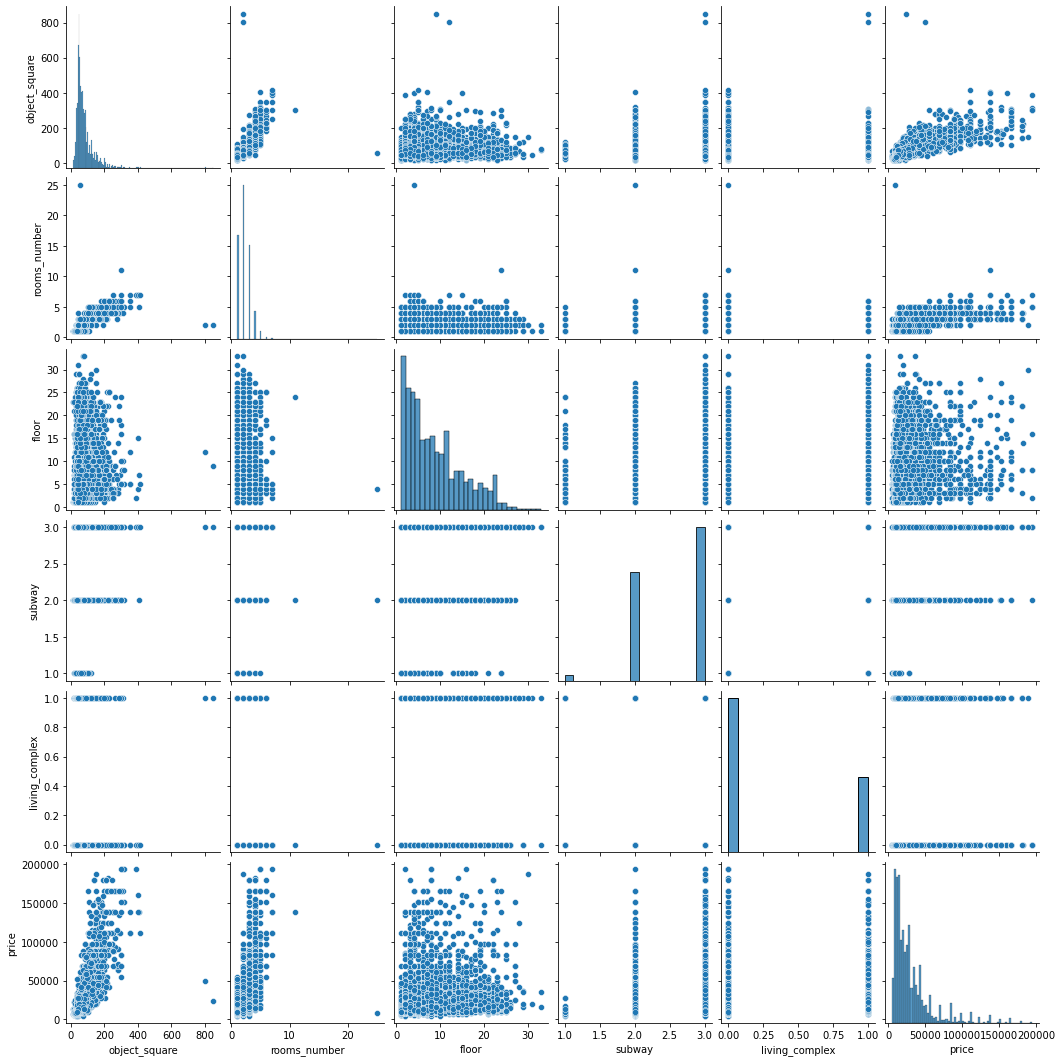

In [353]:
sns.pairplot(rent)

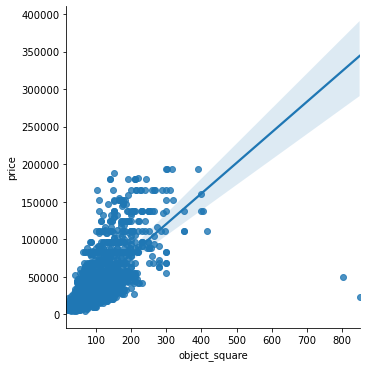

In [354]:
sns.lmplot(x='object_square',y='price',data=rent)

C:\Users\Alyona\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

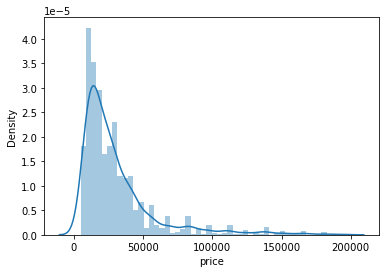

In [355]:
sns.distplot(rent['price'])

In [423]:
X = rent[['object_region', 'object_square', 'rooms_number', 
          'floor', 'subway', 'living_complex']]
y = rent['price']

In [424]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [425]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [426]:
lm.coef_

array([ 878.4240505 ,  317.82607275, 3106.72910615,   64.75792226,
       7601.23500794, 9931.67682821])

In [427]:
lm.score(X_train,y_train)

0.5889851949267007

In [428]:
coeff_rent = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_rent

,Coefficient
object_region,878.424050
object_square,317.826073
rooms_number,3106.729106
floor,64.757922
subway,7601.235008
living_complex,9931.676828


In [429]:
# predictions = lm.predict(X_test)
lm.score(X_test, y_test)

0.6380717804251155

In [430]:
predictions = lm.predict(X_test)

In [431]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 10218.017828386484
MSE: 273608633.221092
RMSE: 16541.11946698566


In [450]:
# передбачаємо ціну квартири в Оболонському районі, площа 60 м2, 2 кімнати, 19-ий поверх, 20 хв до метро, ЖК немає

predictions = lm.predict(np.array([9.7, 60, 2, 19, 2, 0]).reshape(1, -1))
predictions

array([18458.12641279])

In [436]:
dict_with_result = {}

In [437]:
from sklearn.linear_model import LinearRegression
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
print(model_1.score(X_train, y_train))

dict_with_result['LinearRegression'] = f'Test R^2 = {round(model_1.score(X_test, y_test), 2)} '

0.5889851949267007


In [444]:
from sklearn.tree import DecisionTreeRegressor
model_2 = DecisionTreeRegressor(max_depth=5)
model_2.fit(X_train, y_train)
print(model_2.score(X_train, y_train))

dict_with_result['DecisionTreeRegressor'] = f'Test R^2 = {round(model_2.score(X_test, y_test), 2)} '

0.710982255302747


In [445]:
from sklearn.ensemble import RandomForestRegressor
model_3 = RandomForestRegressor()
model_3.fit(X_train, y_train)
print(model_3.score(X_train, y_train))

dict_with_result['RandomForestRegressor'] = f'Test R^2 = {round(model_3.score(X_test, y_test), 2)} '

0.9580231648773903


In [446]:
dict_with_result

{'LinearRegression': 'Test R^2 = 0.64 ',
 'DecisionTreeRegressor': 'Test R^2 = 0.66 ',
 'RandomForestRegressor': 'Test R^2 = 0.7 '}

In [448]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import AdaBoostRegressor

model_1 = LinearRegression()
model_2 = AdaBoostRegressor()
model_3 = RandomForestRegressor()

estimators = [('m2', model_1), ('m3', model_3)]

reg = StackingRegressor(
    estimators=estimators,
    final_estimator=AdaBoostRegressor())

reg.fit(X_train, y_train)

reg.score(X_test, y_test)

0.660865759283934

In [449]:
from sklearn.metrics import r2_score

model_1 = LinearRegression()
model_2 = AdaBoostRegressor()
model_3 = RandomForestRegressor()

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)

y_res = 0.2 * model_1.predict(X_test) + 0.5 * model_2.predict(X_test) + 0.3 * model_3.predict(X_test)

r2_score(y_res, y_test)

0.4957106519347544